In [1]:
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from anndata import AnnData
from squidpy.pl._utils import save_fig
from time import process_time

sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3
sc.settings.dpi = 300
sq.__version__
sc.settings.figdir = "./figures"

%load_ext autoreload
%autoreload 2
%load_ext lab_black

scanpy==1.8.0.dev78+gc488909a anndata==0.7.5 umap==0.4.6 numpy==1.20.1 scipy==1.6.0 pandas==1.2.3 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


In [2]:
adata_visium = sq.datasets.visium_fluo_adata()

In [3]:
ligand = pd.read_csv("./ligand_mouse_giotto.csv.gz")
receptor = pd.read_csv("./receptor_mouse_giotto.csv.gz")

In [4]:
receptor

,select_receptors
0,Lrp1
1,Itga9
2,Itgb1
3,Sdc4
4,Itga5
...,...
554,Fzd5
555,Fzd1
556,Fzd10
557,Lrp5


In [6]:
dic_list = []
for it in [100, 200, 500, 1000]:
    start_t = process_time()
    sq.gr.ligrec(
        adata_visium,
        cluster_key="cluster",
        interactions={
            "source": ligand.select_ligands.values,
            "target": receptor.select_receptors.values,
        },
        n_perms=it,
    )
    duration = process_time() - start_t
    dic_list.append(
        {
            "time": duration,
            "n_obs": adata_visium.shape[0],
            "n_genes": adata_visium.shape[1],
            "n_cluster": adata_visium.obs["cluster"].cat.categories.shape[0],
            "iterations": it,
        }
    )

Running `100` permutations on `559` interactions and `225` cluster combinations using `1` core(s)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Adding `adata.uns['cluster_ligrec']`
Finish (0:00:09)
Running `200` permutations on `559` interactions and `225` cluster combinations using `1` core(s)


  0%|          | 0/200 [00:00<?, ?permutation/s]

Adding `adata.uns['cluster_ligrec']`
Finish (0:00:09)
Running `500` permutations on `559` interactions and `225` cluster combinations using `1` core(s)


  0%|          | 0/500 [00:00<?, ?permutation/s]

Adding `adata.uns['cluster_ligrec']`
Finish (0:00:10)
Running `1000` permutations on `559` interactions and `225` cluster combinations using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?permutation/s]

Adding `adata.uns['cluster_ligrec']`
Finish (0:00:11)


In [14]:
squidpy_res = pd.DataFrame(dic_list)
squidpy_res["tool"] = "squidpy"
squidpy_res

,time,n_obs,n_genes,n_cluster,iterations,tool
0,5.160996,2800,16562,15,100,squidpy
1,5.351492,2800,16562,15,200,squidpy
2,5.917403,2800,16562,15,500,squidpy
3,6.752532,2800,16562,15,1000,squidpy


In [21]:
giotto_res = pd.read_csv("./benchmark_giotto_ligrec.csv", index_col=0)
giotto_res.rename(columns={"mean": "time"}, inplace=True)
giotto_res = giotto_res[["time", "iterations"]].copy()
giotto_res["tool"] = "giotto"
giotto_res

,time,iterations,tool
1,198.833179,100,giotto
2,388.838261,200,giotto
3,969.785029,500,giotto
4,1963.141762,1000,giotto


In [32]:
final_df = pd.concat([squidpy_res, giotto_res], axis=0)
final_df["log_time"] = np.log10(1 + final_df["time"].values)
final_df

,time,n_obs,n_genes,n_cluster,iterations,tool,log_time
0,5.160996,2800.0,16562.0,15.0,100,squidpy,0.789651
1,5.351492,2800.0,16562.0,15.0,200,squidpy,0.802876
2,5.917403,2800.0,16562.0,15.0,500,squidpy,0.839943
3,6.752532,2800.0,16562.0,15.0,1000,squidpy,0.889444
1,198.833179,NaN,NaN,NaN,100,giotto,2.300668
2,388.838261,NaN,NaN,NaN,200,giotto,2.590884
3,969.785029,NaN,NaN,NaN,500,giotto,2.987123
4,1963.141762,NaN,NaN,NaN,1000,giotto,3.293173


In [36]:
data["time"].values[[0, 7]]

array([   5.160996  , 1963.14176232])

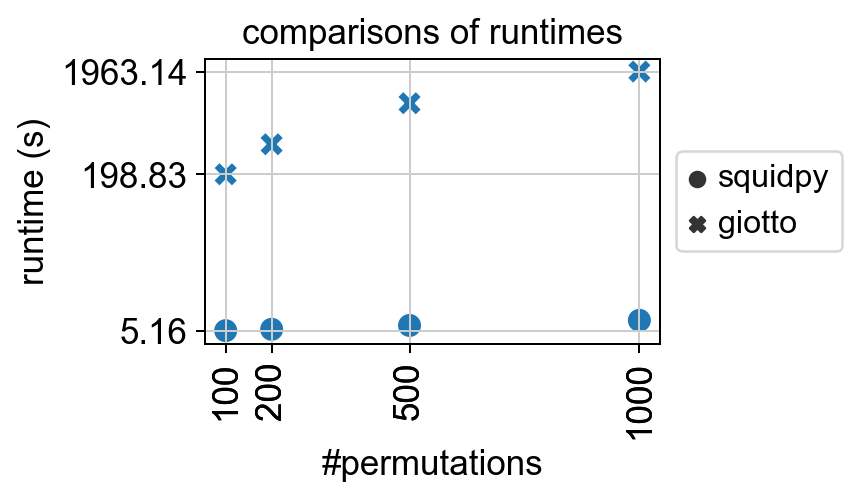

In [39]:
fig, ax = plt.subplots(tight_layout=True, dpi=180, figsize=(5, 3))
data = final_df
sns.scatterplot(data=data, x="iterations", y="log_time", style="tool", s=100, ax=ax)
plt.xticks(data.iterations, data.iterations, rotation=90)
plt.yticks(
    np.round(data.log_time.values[[0, 4, 7]], 2),
    np.round(data["time"].values[[0, 4, 7]], 2),
)
ax.set_ylabel("runtime (s)")
ax.set_xlabel("#permutations")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
_ = ax.set_title("comparisons of runtimes")